# __Preprocesamiento de datos para el perceptron multicapa__

### 1️⃣ __Importacion de modulos__

In [2]:
import dask.dataframe as dd
import pandas as pd
import os
import pickle  # Usado en normalize_data para guardar el scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split  # Usado para dividir datos en train y test
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.optimizers import SGD, Adam

import tensorflow as tf

print("Versión de TensorFlow:", tf.__version__)
print("Dispositivos físicos disponibles:", tf.config.list_physical_devices())
print("Dispositivos GPU:", tf.config.list_physical_devices('GPU'))
print("¿CUDA habilitado?:", tf.test.is_built_with_cuda())
print("¿GPU disponible?:", tf.test.is_gpu_available())

Versión de TensorFlow: 2.10.0
Dispositivos físicos disponibles: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Dispositivos GPU: []
¿CUDA habilitado?: False
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
¿GPU disponible?: False


### 2️⃣ __Leer el CSV preprocesado__

In [3]:
ctu13_df = dd.read_csv('./preprocessing_data/dataset_procesado.csv')

### 3️⃣ __Obtenemos los flujos de red que solamente pertenecen a una botnet__

In [4]:
df_botnets = ctu13_df[ctu13_df['is_botnet'] == 1].copy()
df_botnets.compute().shape

(339700, 17)

### 4️⃣ __Asignamos una etiqueta objetivo idnetificando cada tipo de botnet a clasificar__

In [5]:
escenarios = {0: 'Sogou', 1: 'Murlo', 2: 'Neris', 3: 'RBot', 4: 'NsisAy', 5: 'Virut'}
df_botnets['target'] = df_botnets['BOTNET_NAME'].map({v: k for k, v in escenarios.items()}, meta=('BOTNET_NAME', 'int64'))
df_botnets['target'].value_counts().compute()

target
3    106352
5     40003
1      6127
0        63
2    184987
4      2168
Name: count, dtype: int64

### 5️⃣ __Eliminamos las columnas innecesarias__

In [6]:
df_only_botnets = df_botnets.drop(['StartTime', 'SrcAddr', 'DstAddr', 'State', 'Label', 'is_botnet'], axis=1).copy()
df_only_botnets = df_only_botnets.rename(columns={'BOTNET_NAME': 'label'})

df_only_botnets.compute()

,Dur,Proto,Sport,Dir,Dport,sTos,dTos,TotPkts,TotBytes,SrcBytes,label,target
14659,0.000274,udp,1025.0,<->,53.0,0.0,0.0,2.0,203.0,64.0,Sogou,0
14888,0.010509,udp,1025.0,<->,53.0,0.0,0.0,2.0,590.0,87.0,Sogou,0
14892,0.054527,tcp,1027.0,->,80.0,0.0,0.0,7.0,882.0,629.0,Sogou,0
15090,0.000502,udp,1025.0,<->,53.0,0.0,0.0,2.0,479.0,76.0,Sogou,0
15092,2.995112,udp,123.0,->,123.0,0.0,0.0,2.0,180.0,180.0,Sogou,0
...,...,...,...,...,...,...,...,...,...,...,...,...
411906,1.308413,tcp,23049.0,->,443.0,0.0,0.0,6.0,366.0,186.0,Virut,5
411987,1.207547,tcp,23050.0,->,443.0,0.0,0.0,6.0,366.0,186.0,Virut,5
412081,1.307525,tcp,23051.0,->,443.0,0.0,0.0,6.0,366.0,186.0,Virut,5
412161,1.308276,tcp,23052.0,->,443.0,0.0,0.0,6.0,366.0,186.0,Virut,5


### __Definir columnas numéricas y categóricas__

In [7]:

numerical_columns = ['Dur', 'Sport', 'Dport', 'TotPkts', 'TotBytes', 'SrcBytes']
categorical_columns = list(set(df_only_botnets.columns) - set(numerical_columns))
categorical_columns.remove('target')
categorical_columns.remove('label')
print("Columnas numericas:", numerical_columns)
print("Columnas categoricas:", categorical_columns)

Columnas numericas: ['Dur', 'Sport', 'Dport', 'TotPkts', 'TotBytes', 'SrcBytes']
Columnas categoricas: ['Proto', 'dTos', 'Dir', 'sTos']


### __Normalizar columnas numéricas__

In [8]:
# Convertir de Dask a Pandas antes de continuar
df_only_botnets_pd = df_only_botnets.compute()
print("Tipo de DataFrame:", type(df_only_botnets_pd))

# Normalizar columnas numéricas
scaler = MinMaxScaler()
df_only_botnets_pd[numerical_columns] = scaler.fit_transform(df_only_botnets_pd[numerical_columns])

# Guardar el scaler
pickle.dump(scaler, open(os.path.join('pklfiles', 'scaletrainBotnet.pkl'), 'wb'))

# Crear y ajustar codificadores
ohe_stos = OneHotEncoder(sparse_output=False)
ohe_dtos = OneHotEncoder(sparse_output=False)
ohe_dir = OneHotEncoder(sparse_output=False)
ohe_proto = OneHotEncoder(sparse_output=False)

ohe_stos.fit(df_only_botnets_pd[['sTos']])
ohe_dtos.fit(df_only_botnets_pd[['dTos']])
ohe_dir.fit(df_only_botnets_pd[['Dir']])
ohe_proto.fit(df_only_botnets_pd[['Proto']])

# Aplicar OneHotEncoding y concatenar con Pandas
def apply_onehot_encoding(df, col_name, encoder):
    encoded = encoder.transform(df[[col_name]])
    encoded_df = pd.DataFrame(encoded, dtype='int64', columns=[f'{col_name}_{cat}' for cat in encoder.categories_[0]])
    df = df.drop(columns=[col_name]).reset_index(drop=True)
    return pd.concat([df, encoded_df], axis=1)

# Copiar DataFrame
encoded_df = df_only_botnets_pd.copy()

# Aplicar OneHotEncoder en columnas
encoded_df = apply_onehot_encoding(encoded_df, 'sTos', ohe_stos)
encoded_df = apply_onehot_encoding(encoded_df, 'dTos', ohe_dtos)
encoded_df = apply_onehot_encoding(encoded_df, 'Dir', ohe_dir)
encoded_df = apply_onehot_encoding(encoded_df, 'Proto', ohe_proto)

# Mezclar filas y resetear el índice
encoded_df = encoded_df.sample(frac=1).reset_index(drop=True)

# Separar target y label
target = encoded_df.pop('target')
label = encoded_df.pop('label')

# Resultado final
encoded_df, target, label

Tipo de DataFrame: <class 'pandas.core.frame.DataFrame'>


(             Dur     Sport         Dport   TotPkts      TotBytes  \
 0       0.000039  0.015610  9.646909e-08  0.000006  1.492015e-06   
 1       0.000098  0.023454  9.646909e-08  0.000006  1.398314e-06   
 2       0.000038  0.030397  9.646909e-08  0.000006  1.066755e-06   
 3       0.000000  0.042833  4.452420e-08  0.000000  1.441561e-08   
 4       0.000047  0.023454  9.646909e-08  0.000006  1.304613e-06   
 ...          ...       ...           ...       ...           ...   
 339695  0.000363  0.117284  8.199873e-07  0.000028  2.205588e-06   
 339696  0.000835  0.041323  1.236660e-05  0.000006  4.612995e-07   
 339697  0.000363  0.162147  8.199873e-07  0.000028  2.205588e-06   
 339698  0.000000  0.237743  2.478885e-05  0.000000  7.251051e-06   
 339699  0.000000  0.607312  6.285332e-06  0.000000  7.251051e-06   
 
             SrcBytes  sTos_0.0  dTos_0.0  dTos_2.0  Dir_   ->  Dir_  <->  \
 0       7.207804e-08         1         1         0          0          1   
 1       6.48702

In [9]:
encoded_df.shape

(339700, 15)

In [10]:
target.shape
target.value_counts()

target
2    184987
3    106352
5     40003
1      6127
4      2168
0        63
Name: count, dtype: int64

In [11]:
label.shape
label.value_counts()

label
Neris     184987
RBot      106352
Virut      40003
Murlo       6127
NsisAy      2168
Sogou         63
Name: count, dtype: int64

In [12]:
trainX, testX, trainY, testY = train_test_split(encoded_df, target, test_size=0.3)

In [13]:
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(237790, 15)
(101910, 15)
(237790,)
(101910,)


In [14]:
pickle.dump((trainX, testX, trainY, testY), open(os.path.join('pklfiles', 'dataBotNetMLP.pkl'), "wb"))

In [15]:
def getmodel(inputShape):
    inputs = Input(shape=inputShape)
    x = Dense(128)(inputs)
    x = Activation('relu')(x)
#     x = Dense(512)(x)
#     x = Activation('relu')(x)
    x = Dense(1024)(x)
    x = Activation('relu')(x)
#     x = Dense(1024)(x)
#     x = Activation('relu')(x)
#     x = Dense(512)(x)
#     x = Activation('relu')(x)
    x = Dense(512)(x)
    x = Activation('relu')(x)
    x = Dense(128)(x)
    x = Activation('relu')(x)   
    x = Dense(128)(x)
    x = Activation('relu')(x)
    x = Dense(10)(x)
    x = Activation('relu')(x)
    x = Dense(6)(x)
    outputs = Activation('softmax')(x)
    
    model = Model(inputs, outputs)
    
    return model

In [16]:
model = getmodel(15)

In [17]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])

In [18]:
trainY

28671     3
71318     3
112918    3
181938    5
319960    5
         ..
107273    3
152143    2
264223    3
82104     3
310422    2
Name: target, Length: 237790, dtype: int64

In [19]:
encY = OneHotEncoder()
trainY = encY.fit_transform(trainY.values.reshape(-1,1))

In [20]:
trainY = trainY.toarray()
trainY

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.]])

In [21]:
history = model.fit(trainX,trainY,epochs=100,validation_split=0.2,batch_size=128)
#history = model.fit(trainX,trainY,epochs=500,validation_split=0.2,batch_size=128)

Epoch 1/100
1487/1487 [==============================] - 16s 10ms/step - loss: 0.3604 - accuracy: 0.8890 - val_loss: 0.3049 - val_accuracy: 0.9081
Epoch 2/100
1487/1487 [==============================] - 17s 12ms/step - loss: 0.3082 - accuracy: 0.9087 - val_loss: 0.3174 - val_accuracy: 0.9111
Epoch 3/100
1487/1487 [==============================] - 20s 13ms/step - loss: 0.3153 - accuracy: 0.9068 - val_loss: 0.2967 - val_accuracy: 0.9127
Epoch 4/100
1487/1487 [==============================] - 17s 11ms/step - loss: 0.3038 - accuracy: 0.9099 - val_loss: 0.3000 - val_accuracy: 0.9125
Epoch 5/100
1487/1487 [==============================] - 17s 12ms/step - loss: 0.3020 - accuracy: 0.9103 - val_loss: 0.2956 - val_accuracy: 0.9128
Epoch 6/100
1487/1487 [==============================] - 15s 10ms/step - loss: 0.3003 - accuracy: 0.9110 - val_loss: 0.2940 - val_accuracy: 0.9123
Epoch 7/100
1487/1487 [==============================] - 14s 9ms/step - loss: 0.2975 - accuracy: 0.9114 - val_loss: 0.

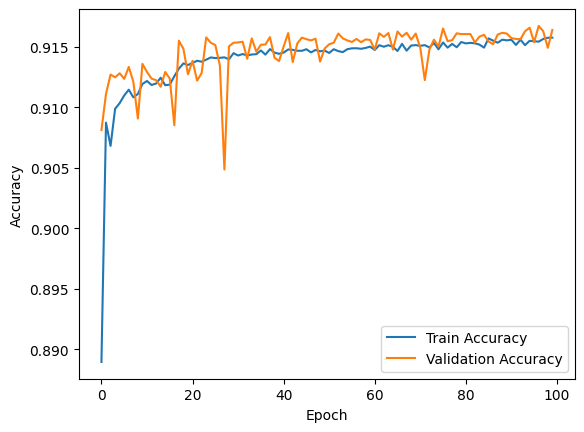

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.plot(history.history['loss'], label='Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

3185/3185 [==============================] - 12s 4ms/step
307439    2
13718     3
300257    3
8241      3
261125    2
         ..
91226     2
44964     2
237924    3
20204     3
40965     5
Name: target, Length: 101910, dtype: int64


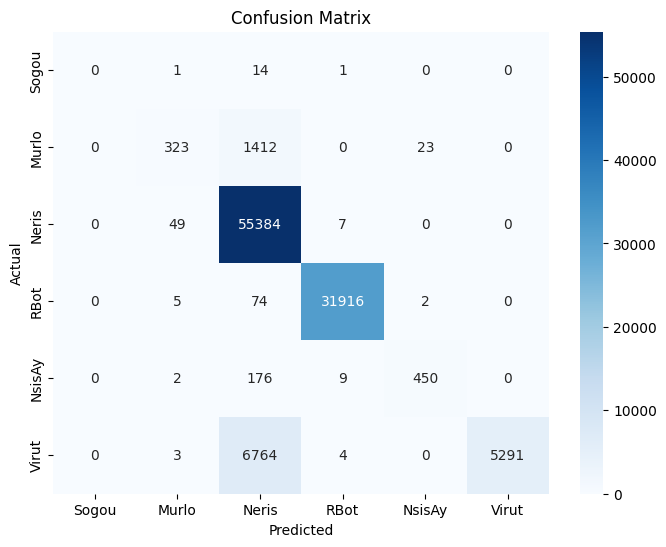

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.84      0.18      0.30      1758
           2       0.87      1.00      0.93     55440
           3       1.00      1.00      1.00     31997
           4       0.95      0.71      0.81       637
           5       1.00      0.44      0.61     12062

    accuracy                           0.92    101910
   macro avg       0.78      0.55      0.61    101910
weighted avg       0.92      0.92      0.90    101910



c:\Users\t4v0s\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\t4v0s\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\t4v0s\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [23]:
predictions = model.predict(testX)
predictions = predictions.argmax(axis=1)  # Si es clasificación multiclase
#true_labels = testY.argmax(axis=1)
true_labels = testY.copy()
print(true_labels)
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Sogou','Murlo','Neris','RBot','NsisAy','Virut'], yticklabels=['Sogou','Murlo','Neris','RBot','NsisAy','Virut'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Reporte de métricas
print(classification_report(true_labels, predictions))

### __Ajustar codificadores one-hot__